# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *


In [ ]:
vgg16 = VGG16(weights = 'imagenet',
              input_shape = (32, 32, 3), include_top = False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,849,610
Trainable params: 14,849,098
Non-trainable params: 512
__________________________________________

In [ ]:
mobilenet = MobileNet(weights = None, input_shape = None, include_top = True)

resnet50 = ResNet50(weights = None, input_shape = None, include_top = True)

xception = Xception(weights = None, input_shape = None, include_top = True)



### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')



#### 데이터 로드

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2020-09-15 20:39:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   141MB/s    in 0.5s    

2020-09-15 20:39:52 (141 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
ls

cats_and_dogs_filtered.zip  sample_data/


In [ ]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)



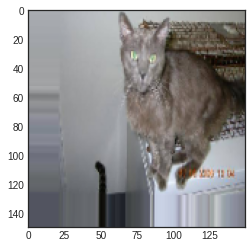

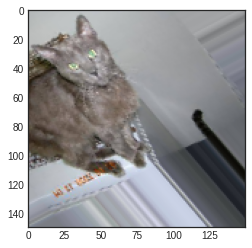

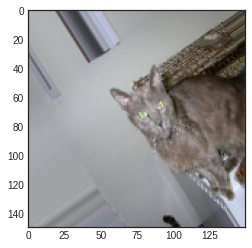

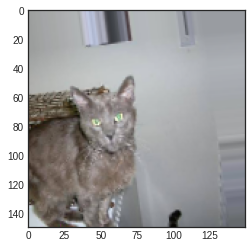

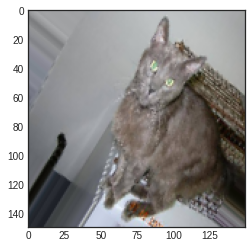

In [ ]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size = (150, 150))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break


#### 학습, 검증 데이터셋의 Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=1e-4),
              metrics = ['acc'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [ ]:
hist = model.fit(train_generator,
                 steps_per_epoch = 100,
                 epochs = 30,
                 batch_size = 256,
                 validation_data = validation_generator,
                 validation_steps = 50,
                 verbose = 2)

Epoch 1/30
100/100 - 16s - loss: 0.6894 - acc: 0.5385 - val_loss: 0.6768 - val_acc: 0.5490
Epoch 2/30
100/100 - 16s - loss: 0.6801 - acc: 0.5640 - val_loss: 0.7600 - val_acc: 0.5050
Epoch 3/30
100/100 - 16s - loss: 0.6693 - acc: 0.5895 - val_loss: 0.6340 - val_acc: 0.6540
Epoch 4/30
100/100 - 16s - loss: 0.6506 - acc: 0.6210 - val_loss: 0.6254 - val_acc: 0.6290
Epoch 5/30
100/100 - 16s - loss: 0.6302 - acc: 0.6550 - val_loss: 0.5931 - val_acc: 0.6800
Epoch 6/30
100/100 - 16s - loss: 0.6106 - acc: 0.6540 - val_loss: 0.5678 - val_acc: 0.6990
Epoch 7/30
100/100 - 16s - loss: 0.6135 - acc: 0.6575 - val_loss: 0.6153 - val_acc: 0.6600
Epoch 8/30
100/100 - 16s - loss: 0.5926 - acc: 0.6910 - val_loss: 0.5597 - val_acc: 0.7010
Epoch 9/30
100/100 - 16s - loss: 0.5951 - acc: 0.6805 - val_loss: 0.5893 - val_acc: 0.6750
Epoch 10/30
100/100 - 16s - loss: 0.5771 - acc: 0.6860 - val_loss: 0.5452 - val_acc: 0.7180
Epoch 11/30
100/100 - 16s - loss: 0.5723 - acc: 0.7005 - val_loss: 0.5724 - val_acc: 0.68

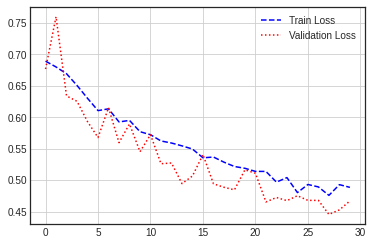

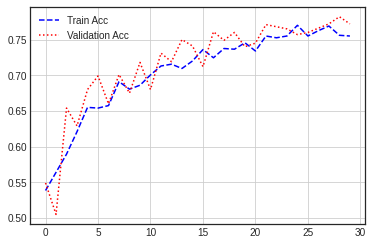

In [ ]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label = 'Train Loss')
plt.plot(epochs, val_loss, 'r:', label = 'Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label = 'Train Acc')
plt.plot(epochs, val_acc, 'r:', label = 'Validation Acc')
plt.grid()
plt.legend()

plt.show()


#### 모델 저장

In [ ]:
model.save("cats_and_dogs_model.h5")

### 사전 훈련된 모델 사용

In [ ]:
conv_base = VGG16(weights = 'imagenet',
                  input_shape = (150, 150, 3),
                  include_top = False)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
    model = Sequential()

    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(learning_rate = 1e-5),
                  metrics = ['accuracy'])
    
    return model

파라미터의 수 확인!

In [ ]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [ ]:
print(len(model.trainable_weights)) # 30


30


In [ ]:
conv_base.trainable = False
print(len(model.trainable_weights)) # 가중치 학습 막기 위해 동결

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 2e-5),
              metrics = ['accuracy'])

#### 이미지 제너레이터

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [ ]:
hist2 = model.fit(train_generator,
                 steps_per_epoch = 100,
                 epochs = 30,
                 batch_size = 256,
                 validation_data = validation_generator,
                 validation_steps = 50,
                 verbose = 2)

Epoch 1/30
100/100 - 18s - loss: 0.6089 - accuracy: 0.6850 - val_loss: 0.4624 - val_accuracy: 0.8160
Epoch 2/30
100/100 - 18s - loss: 0.4934 - accuracy: 0.7885 - val_loss: 0.3837 - val_accuracy: 0.8470
Epoch 3/30
100/100 - 18s - loss: 0.4411 - accuracy: 0.8035 - val_loss: 0.3490 - val_accuracy: 0.8570
Epoch 4/30
100/100 - 18s - loss: 0.4050 - accuracy: 0.8240 - val_loss: 0.3378 - val_accuracy: 0.8500
Epoch 5/30
100/100 - 18s - loss: 0.3894 - accuracy: 0.8305 - val_loss: 0.3078 - val_accuracy: 0.8670
Epoch 6/30
100/100 - 18s - loss: 0.3728 - accuracy: 0.8325 - val_loss: 0.3000 - val_accuracy: 0.8760
Epoch 7/30
100/100 - 18s - loss: 0.3575 - accuracy: 0.8500 - val_loss: 0.2831 - val_accuracy: 0.8790
Epoch 8/30
100/100 - 18s - loss: 0.3501 - accuracy: 0.8420 - val_loss: 0.2870 - val_accuracy: 0.8810
Epoch 9/30
100/100 - 18s - loss: 0.3401 - accuracy: 0.8480 - val_loss: 0.2716 - val_accuracy: 0.8820
Epoch 10/30
100/100 - 18s - loss: 0.3336 - accuracy: 0.8615 - val_loss: 0.2683 - val_accura

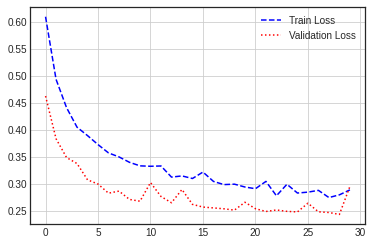

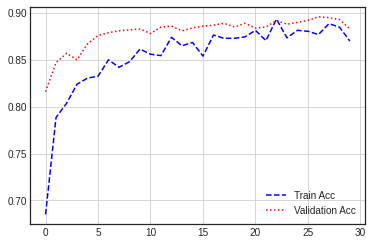

In [ ]:
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label = 'Train Loss')
plt.plot(epochs, val_loss, 'r:', label = 'Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label = 'Train Acc')
plt.plot(epochs, val_acc, 'r:', label = 'Validation Acc')
plt.grid()
plt.legend()

plt.show()


#### 모델 저장

In [ ]:
model.save("cats_and_dogs_with_pretrained_model.h5")

## Feature Map 시각화

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [ ]:
model = load_model("/content/cats_and_dogs_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


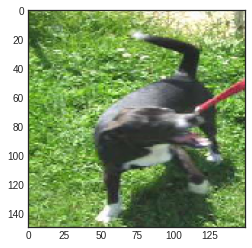

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
conv_output = [layer.output for layer in model.layers[:8]]

conv_output

[<tf.Tensor 'conv2d_4/Relu_1:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool_1:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu_1:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool_1:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu_1:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool_1:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu_1:0' shape=(None, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool_1:0' shape=(None, 7, 7, 128) dtype=float32>]

In [ ]:
activation_model = Model(inputs = [model.input],
                         outputs = conv_output)

In [ ]:
activations = activation_model.predict(img_tensor)


In [ ]:
len(activations) # 8

8

### 시각화

(1, 148, 148, 32)


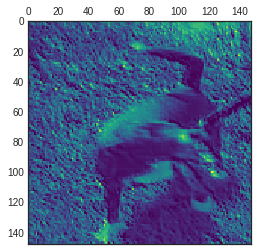

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 7], cmap = 'viridis')
plt.show()

(1, 148, 148, 32)


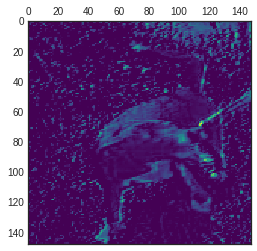

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap = 'viridis')
plt.show()

(1, 148, 148, 32)


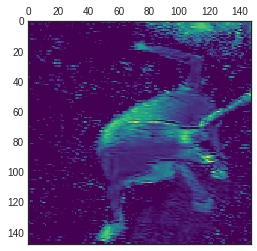

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 20], cmap = 'viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

In [ ]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    num_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))

    for col in range(num_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[col * size: (col + 1) * size, row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size

    plt.figure(figsize = (scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

plt.show()

Output hidden; open in https://colab.research.google.com to view.